# 1. Lineární regrese

## The Boston Housing Dataset

V minulém cvičení jsme zjistili, že výstupní proměnná MEDV je lineárně závislá na vstupních proměnnách LSTAT a RM.

* RM - průměrný počet pokojů na byt (vstupní proměnná)
* LSTAT - procentuálně nižší stav populace (vstupní proměnná)
* MDEV - mediánová hodnota obydlí obývaných vlastníky v 1000 USD (výstupní proměnná)

## Cíl
Cílem tohoto cvičení je vytvoření lineárního modelu, který na základě vstupní hodnoty RM a LSTAT odhadne MDEV.

## 1.1 Příprava dat

### 1.1.1 Načtení dat

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

In [4]:
data = pd.read_csv ("../dataset/HousingData.csv")

### 1.1.2 Vyčištění dat

Odebrání záznamů s NULL hodnotami.

In [5]:
data=data.dropna()

Odebrání extrémních hodnot
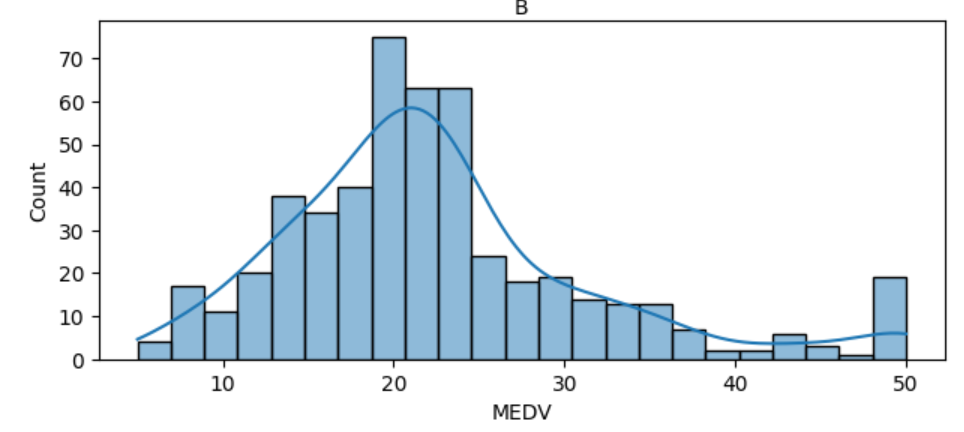

In [6]:
data = data[~(data['MEDV'] >= 40.0)]

## 1.2 Lineární model s jednou proměnnou

Pro názornost nejprve vytvoříme model, který bude predikovat hodnotu MEDV z jedné vstupní proměnné RM

### 1.2.1 Převedení hodnot z pandas na numpy pole

In [7]:
import numpy as np

Data rozdělíme na vstupní parametry X a výsledky Y.

In [8]:
X = pd.DataFrame(np.c_[data['RM']], columns = ['RM'])
Y = data['MEDV']

In [9]:
X.describe()

,RM
count,371.000000
mean,6.189722
std,0.592102
min,3.561000
25%,5.870500
50%,6.164000
75%,6.512000
max,8.780000


In [10]:
Y.describe()

count    371.000000
mean      20.818868
std        6.883723
min        5.000000
25%       16.400000
50%       20.600000
75%       24.250000
max       39.800000
Name: MEDV, dtype: float64

### 1.2.2 Rozdělení souboru dat na trénovací, testovací a validační podmnožinu

Pro učení budeme používat knihovnu scikit-learn s algoritmy pro učení s a bez učitele.

**pip install scikit-learn**

In [11]:
from sklearn.model_selection import train_test_split

Dataset rozdělíme na 3 části - trénovací, validační a testovací dat

In [12]:
def split_dataset (X, Y, train_ratio = 0.75, validation_ratio = 0.15, test_ratio = 0.10):
    """ Slitting the dataset into training, validation and testing subset
        X - explanatory variables
        Y - explained variables

        train_ratio      - training data ratio
        validation_ratio - validation data ratio
        test_ratio       - ratio of test data

    """
    assert(train_ratio + validation_ratio + test_ratio == 1.0)

    # train nyní tvoří 75 % celého souboru dat
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)

    # test je nyní 10 % původního souboru dat
    # nyní představuje 15 % původního souboru dat
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [13]:
# kontrola velikosti data subsets
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)
print (X_train.shape, Y_train.shape)
print (X_val.shape, Y_val.shape)
print (X_test.shape, Y_test.shape)

(278, 1) (278,)
(55, 1) (55,)
(38, 1) (38,)


### 1.2.3 Ruční lineární regrese

In [14]:
import random

In [15]:
def initialize(dim):
    """ Initial linear model parameter settings - bias and weights
    """
    bias=random.random()
    weights=np.random.rand(dim)
    return bias, weights

In [16]:
def print_model_params(bias, weights):
    """Printing the current model parameters
    """
    print ("Model parameters\n================")
    print(f"Bias: {bias}")
    print (f"Weights: {weights}")  

In [17]:
bias, weights=initialize(X.shape[1])
print_model_params(bias, weights)

Model parameters
Bias: 0.1697693038096253
Weights: [0.84329806]


In [18]:
def predict(X, bias, weights):
    """ Based on the model parameters (bias and weights), the function calculates the output values Y from the input values X
        X - input numpy matrix
        bias - model parameter b
        weights - array of weights

        Returns matrix of predicted values Y
    """
    return bias + np.dot(X, weights)

In [19]:
# vyzkoušení predikce Y hodnot na trénovací množině
print ("Predicted values\n================")
Y_predicted = predict(X_train, bias, weights)
Y_predicted[0:10]

Predicted values


array([6.42704088, 5.35099256, 5.83251575, 5.21775147, 5.16546699,
       5.69252827, 5.37038842, 5.27256584, 5.5947057 , 5.64024379])

In [20]:
def visualize_model_2d (X, Y, Y_predicted):
    """ Visualization of simple linear model in 2D
        X - real input data
        Y - real output data
        Y_predicted - predicted output data
    """
    plt.figure() 
    plt.plot (X, Y_predicted, c='b', label = "Train prediction")
    plt.scatter (X, Y, marker = 'x', c='r', label="Train actual")
    plt.title ("Model")
    plt.ylabel("$")
    plt.xlabel("RM")
    plt.legend()
    plt.show()

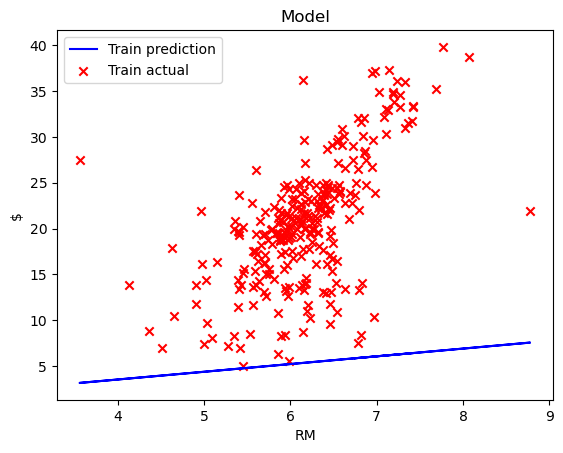

In [21]:
visualize_model_2d(X_train, Y_train, Y_predicted)

### 1.2.4 Nákladová funkce
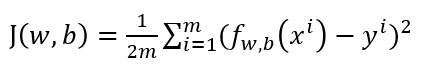

In [22]:
# nákladová funkce odnotí, jak moc se skutečné hodnoty liší od modelem předpovezených hodnot
def get_cost(Y, Y_predicted):
    """ Return MSE for real and predicted ouput data
    """
    Y_resd = Y - Y_predicted
    return np.sum(np.dot(Y_resd.T,Y_resd))/(len(Y-Y_resd)*2)

In [23]:
def print_cost (Y_train, Y_predicted):
    print (f"Cost function MSE: {get_cost(Y_train, Y_predicted)}")

In [24]:
print_cost(Y_train, Y_predicted)

Cost function MSE: 137.9969342603072


### 1.2.5 Hodnocení modelu
Pro hodnocení modelu použijeme: 
- R2 funkce (R-squared, coefficient of determination, regression score function). Hodnota pro model, který bezchybně předvídá data je 1.0. Větší hodnota je lepší.
- RMSE (root mean square error). Menší hodnota je lepší

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
def print_model_score(Y_train, Y_predicted):
    """ Printing model score
    """
    r2 = r2_score(Y_train, Y_predicted)
    rmse = (np.sqrt(mean_squared_error(Y_train, Y_predicted)))    
    print('R2 score: {}'.format(r2))    
    print('RMSE: {}'.format(rmse))

In [27]:
print_model_score (Y_train, Y_predicted)

R2 score: -4.821838690741832
RMSE: 16.61306318896712


### 1.2.6 Jedna iterace učení
Parametry modelu máme nastavené na náhodné hodnoty. V této sekci provedeme jednu iteraci učení. 

Po jejím dokončení by skóre modelu mělo být lepší.

In [28]:
def update_weights(X, Y, Y_predicted, bias_0, weights_0, learning_rate):
    """ The function adjusts the model parameters bias and weights

        X - input values
        Y - correct output values
        Y_predicted - predicted values
        bias_0 - current value of bias
        weights_0 - current values of weights
        learning_rate - learning rate alpha

    """

    # výpočet parciálních derivací
    delta_bias = (np.sum(Y_predicted - Y))/len(Y)
    delta_weights = (np.dot((Y_predicted - Y),X))/len(Y)

    # výpočet úpravy parametrů modelu
    bias_1 = bias_0 - learning_rate * delta_bias
    weights_1 = weights_0 - learning_rate * delta_weights
    return bias_1, weights_1

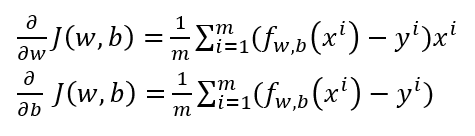

In [29]:
# 1. iterace učení
Y_predicted = predict(X_train, bias, weights)
bias, weights = update_weights(X_train, Y_train, Y_predicted, bias, weights, 0.01)
print_model_params(bias, weights)

Model parameters
Bias: 0.32232594186708274
Weights: [1.80696598]


In [30]:
Y_predicted = predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)

Cost function MSE: 61.559708894320565


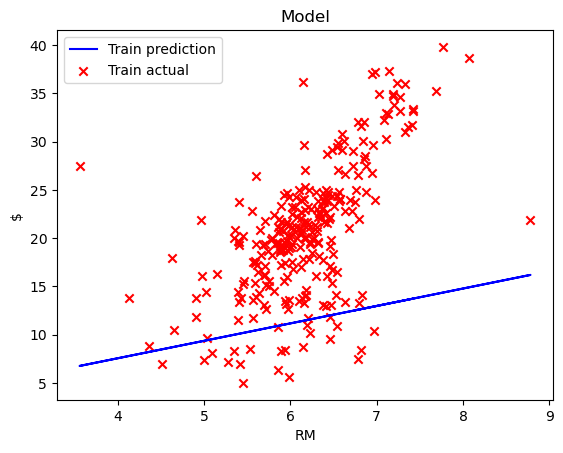

In [31]:
# graf porovnejte s předchozím
visualize_model_2d(X_train, Y_train, Y_predicted)

In [32]:
# skóre porovnejte s předchozím
print_model_score (Y_train, Y_predicted)

R2 score: -1.597091717673364
RMSE: 11.095918969992576


### 1.2.7 Celé učení

In [33]:
def run_gradient_descent(X, Y, learning_rate, num_iterations):
    """ Algoritmus gradient descent 
        X - input data
        Y - output data
        learning_rate - learning rate alpha
        num_iteration - number of iteration    

        gd_iterations_df - history of learning
        bias             - bias parameter
        weights          - weights parameter
    """
    # inicializace parametrů modelu
    bias, weights=initialize(X.shape[1])
    iter_num=0

    # ukladání postupu učení do dataFrame
    gd_iterations_df=pd.DataFrame(columns=['iteration','cost'])
    result_idx=0
    
    for each_iter in range(num_iterations):
        # kontrolní zobrazení skóre
        Y_predicted = predict(X, bias, weights)
        this_cost=get_cost(Y, Y_predicted)

        # vylepšení parametrů
        prev_bias=bias
        prev_weights=weights
        bias, weights = update_weights(X, Y, Y_predicted, prev_bias, prev_weights, learning_rate)

        # uložení každé 10. iterace do historie učen
        if(iter_num % 10==0):
            gd_iterations_df.loc[result_idx]=[iter_num, this_cost]
            result_idx=result_idx+1

        iter_num +=1    
    return gd_iterations_df, bias, weights

In [34]:
# Naučení modelu
gd_iterations_df, bias, weights=run_gradient_descent(X_train, Y_train, learning_rate=0.001, num_iterations=200)

In [35]:
# Vypsání modelu
print_model_params(bias, weights)
Y_predicted=predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Model parameters
Bias: 0.9030969650433731
Weights: [3.23225406]
Cost function MSE: 17.28684509190301
R2 score: 0.2706995692595656
RMSE: 5.879939641170308


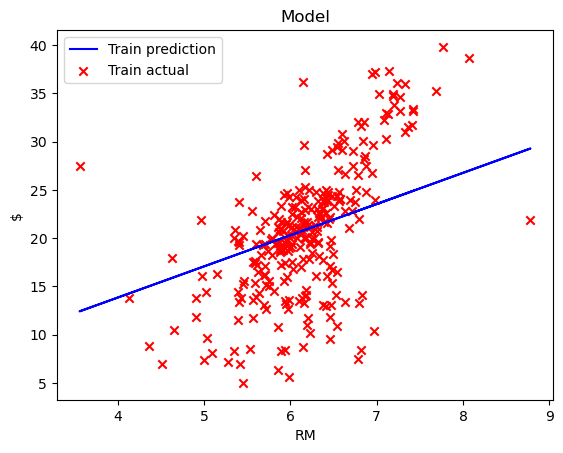

In [36]:
visualize_model_2d(X_train, Y_train, Y_predicted)

### 1.2.8 Validace modelu

In [37]:
# kontrola modelu na datech, ktera nebyla použita pro učeni
Y_val_predicted = predict(X_val, bias, weights)
print_cost(Y_val, Y_val_predicted)
print_model_score(Y_val, Y_val_predicted)

Cost function MSE: 22.77079078839724
R2 score: 0.22352297158495915
RMSE: 6.74845030927801


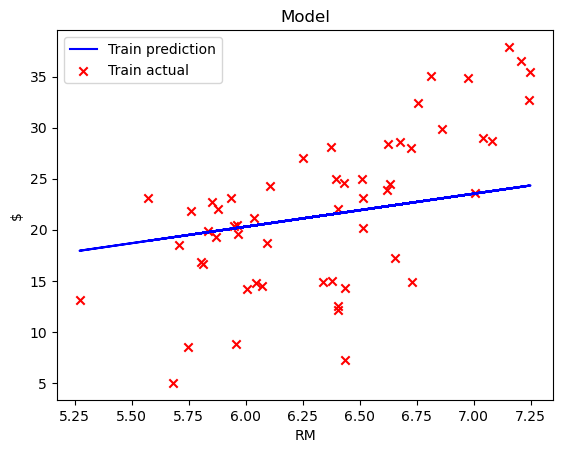

In [38]:
visualize_model_2d(X_val, Y_val, Y_val_predicted)

### 1.2.9 Proces učení

Text(0, 0.5, 'Cost or MSE')

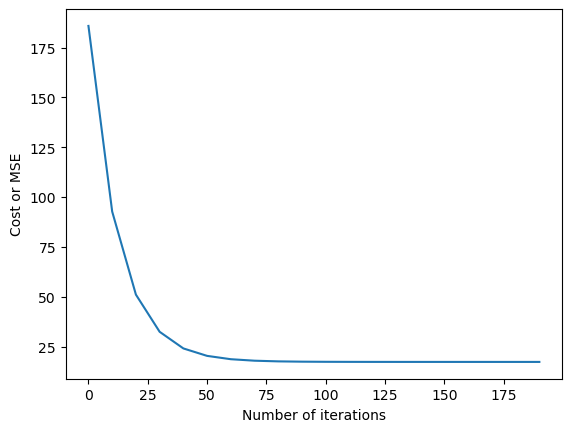

In [39]:
# zobrazení, jak s počtem iterací klesá hodnota nákladové funkce
plt.plot(gd_iterations_df['iteration'], gd_iterations_df['cost'])
plt.xlabel("Number of iterations")
plt.ylabel("Cost or MSE")

In [40]:
# porovnání vlivu velikosti learning rate na rychlost učeni
alpha_df_1, bias_1, weights_1=run_gradient_descent(X_train, Y_train, learning_rate=0.01, num_iterations=200)
alpha_df_2, bias_2, weights_2=run_gradient_descent(X_train, Y_train, learning_rate=0.001, num_iterations=200)

Model parameters
Bias: 0.9040771978968848
Weights: [3.23305077]
Cost function MSE: 17.28701067770845


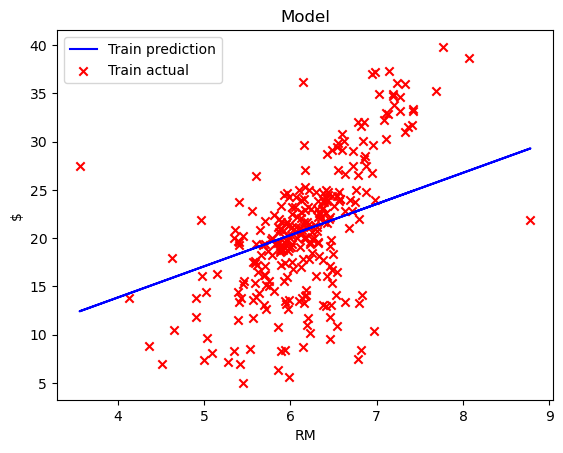

In [41]:
print_model_params(bias_1, weights_1)
Y_predicted_1 = predict(X_train, bias_1, weights_1)
print_cost(Y_train, Y_predicted_1)
visualize_model_2d(X_train, Y_train, Y_predicted_1)

Model parameters
Bias: 1.0670055185609821
Weights: [3.20600598]
Cost function MSE: 17.323090304401074


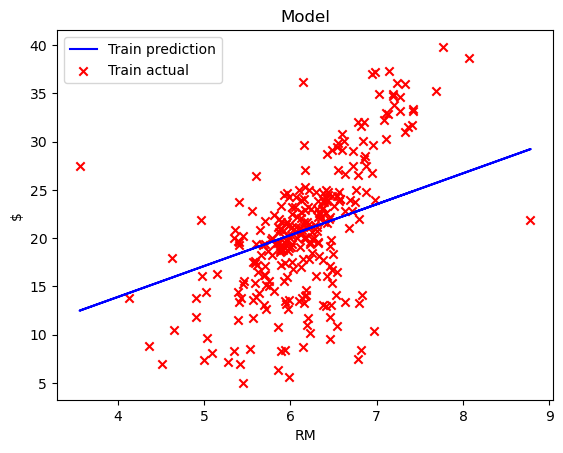

In [42]:
print_model_params(bias_2, weights_2)
Y_predicted_2 = predict(X_train, bias_2, weights_2)
print_cost(Y_train, Y_predicted_2)
visualize_model_2d(X_train, Y_train, Y_predicted_2)

Text(0.5, 1.0, 'Cost vs. Iterations for different alpha values')

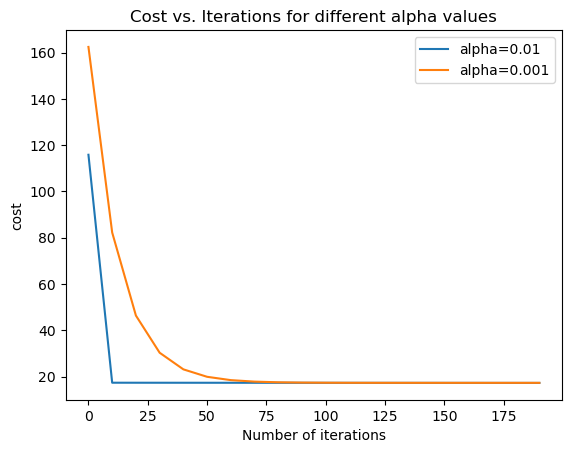

In [43]:
# rychlost vytrénování modelu pro různa learning rate alpha
plt.plot(alpha_df_1['iteration'],alpha_df_1['cost'],label="alpha=0.01")
plt.plot(alpha_df_2['iteration'],alpha_df_2['cost'],label="alpha=0.001")
plt.legend()
plt.ylabel('cost')
plt.xlabel('Number of iterations')
plt.title('Cost vs. Iterations for different alpha values')

## 1.3 Lineární model s více proměnnými

Vytvoříme model se dvěma parametry RM a LSTAT.

### 1.3.1 Příprava data

In [44]:
X = pd.DataFrame(np.c_[data['RM'],data['LSTAT']], columns = ['RM', 'LSTAT']).to_numpy()
Y = data['MEDV'].to_numpy()

In [45]:
# kontrola velikosti dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_dataset(X, Y)
print(X_train.shape, Y_train.shape)
print (X_val.shape, Y_val.shape)
print (X_test.shape, Y_test.shape)

(278, 2) (278,)
(55, 2) (55,)
(38, 2) (38,)


### 1.3.2 Vizualizace dat ve 3D

In [46]:
x_label, y_label, z_label = "Living Area (m²)", "Bedrooms", "Price"
X1 = X_train[:, 0]  # 1. sloupec
X2 = X_train[:, 1]  # 2. sloupec
Y = Y_train  # Cílová proměnná
    
# Vytvoření 3D scatter plotu
fig = go.Figure()

# Scatter plot - body dat
fig.add_trace(go.Scatter3d(
        x=X1, y=X2, z=Y,
        mode='markers',
        marker=dict(size=5, color=Y, colorscale='Viridis', opacity=0.8),
        name="Data"
))
fig.show()

### 1.3.3 Jedna iterace

In [47]:
# inicializace parametru modelu
bias, weights=initialize(X.shape[1])
print_model_params(bias, weights)

Model parameters
Bias: 0.9041994389863812
Weights: [0.89325146 0.24895346]


In [48]:
# vyzkoušeni predikce modelu na náhodných parametrech modelu
Y_predicted=predict(X_train, bias, weights)
Y_predicted[0:10]

array([ 8.30988106,  8.74482209,  9.47864852, 13.30073715,  8.87081067,
       10.58070925,  8.34928524, 12.40819339,  8.25813918, 10.35603254])

In [49]:
# počáteční hodnota nákladové funkce
print_cost(Y_train, Y_predicted)

Cost function MSE: 91.49682668789544


In [50]:
# počáteční skóre modelu
print_model_score (Y_train, Y_predicted)

R2 score: -2.9422776176113343
RMSE: 13.527514678454091


In [51]:
def visualize_model_3D(X1, X2, Y, bias, weights, points=50):      
    # Popisky os
    x_label, y_label, z_label = "Living Area (m²)", "Bedrooms", "Price"
    
    # Vytvoření 3D scatter plotu
    fig = go.Figure()

    # Scatter plot - body dat
    fig.add_trace(go.Scatter3d(
        x=X1, y=X2, z=Y,
        mode='markers',
        marker=dict(size=5, color=Y, colorscale='Viridis', opacity=0.8),
        name="Data"
    ))

    # Modelová plocha
    x_range = np.linspace(min(X1), max(X1), points)
    y_range = np.linspace(min(X2), max(X2), points)
    xs, ys = np.meshgrid(x_range, y_range)
    zs = xs * weights[0] + ys * weights[1] + bias  # Modelová predikce

    fig.add_trace(go.Surface(
        x=xs, y=ys, z=zs,
        colorscale="Blues",
        opacity=0.5,
        name="Model Surface"
    ))

    # Aktualizace layoutu
    fig.update_layout(
        title="3D Model Visualization",
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label
        )
    )

    # Zobrazení grafu
    fig.show()

In [52]:
visualize_model_3D (X1, X2, Y_train, bias, weights, 30)

In [53]:
# provedení první iterace
bias, weights = update_weights(X_train, Y_train, Y_predicted, bias, weights, 0.01)

In [54]:
# nové parametry modelu
print_model_params(bias, weights)

Model parameters
Bias: 1.0136373646286454
Weights: [1.5994358  1.22922684]


In [55]:
# skóre modelu
Y_predicted=predict(X_train, bias, weights, )
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Cost function MSE: 122.49611080748834
R2 score: -4.27792813545397
RMSE: 15.6522273691311


### 1.3.4 Celé učení

In [56]:
# spuštění učení
gd_iterations_df, bias, weights=run_gradient_descent(X_train,Y_train, learning_rate=0.001, num_iterations=500)

In [57]:
# parametry modelu
print_model_params(bias, weights)

Model parameters
Bias: 0.6880913612871519
Weights: [ 4.3306602 -0.5104341]


In [58]:
# skóre modelu
Y_predicted=predict(X_train, bias, weights)
print_cost(Y_train, Y_predicted)
print_model_score (Y_train, Y_predicted)

Cost function MSE: 8.039657308770575
R2 score: 0.6535993409941436
RMSE: 4.009902070816836


In [59]:
visualize_model_3D(X1, X2, Y_train, bias, weights, 40)

### 1.3.5 Validace modelu

In [60]:
Y_val_predicted = predict(X_val, bias, weights, )
print_cost(Y_val, Y_val_predicted)
print_model_score (Y_val, Y_val_predicted)

Cost function MSE: 8.393145125243928
R2 score: 0.5890145370069568
RMSE: 4.097107546853982


### 1.3.5 Proces učení

Text(0, 0.5, 'Cost or MSE')

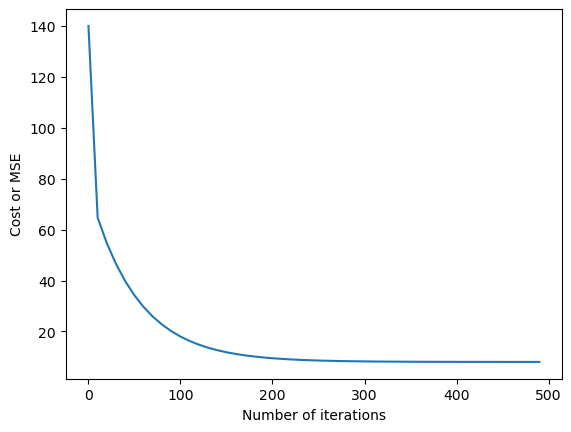

In [61]:
# zobrazení historie učení
fig2=plt.figure()
plt.plot(gd_iterations_df['iteration'], gd_iterations_df['cost'])
plt.xlabel("Number of iterations")
plt.ylabel("Cost or MSE")

## 1.4 Lineární model z scikit-sklearn
scikit-sklearn je knihovna pro strojové učení

### 1.4.1 Vytrénování modelu

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
# vytvoření linearního modelu
lin_model = LinearRegression()

In [64]:
# trénování modelu na tréninkových datech
lin_model.fit(X_train, Y_train)

LinearRegression()

In [65]:
print ("Bias: ", lin_model.intercept_)
print("Weights: ", lin_model.coef_)

Bias:  10.270887112773307
Weights:  [ 2.99085103 -0.60100836]


In [66]:
# predikce hodnot
Y_predicted = lin_model.predict(X_train)

In [67]:
print_model_score(Y_train, Y_predicted)

R2 score: 0.6622694262472417
RMSE: 3.9594020226526268


In [68]:
visualize_model_3D(X1, X2, Y_train, lin_model.intercept_, lin_model.coef_, 40)

### 1.4.2 Ověření modelu

In [69]:
Y_val_predict = lin_model.predict(X_val)

In [70]:
print_model_score(Y_val, Y_val_predict)

R2 score: 0.6017287676671657
RMSE: 4.033235700204277


### 1.4.3 Uložení modelu do souboru

In [71]:
import pickle
filename = 'regression_linear_model.sav'
pickle.dump(lin_model, open(filename, 'wb'))

In [72]:
loaded_model = pickle.load(open(filename, 'rb'))